# The Pre-FOMC Drift and the Secular Decline in Long-Term Interest Rates

Whitepaper [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4764451)

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
from matplotlib.legend_handler import HandlerPatch


from FOMCDataPrep import DataPrep

Access ```BBGEventCollect``` module

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\BBGEvent\root")
from BBGEventCollect import BBGCollect

In [3]:
def prep_yields() -> pd.DataFrame: 

    df_yield = (DataPrep().get_tsy_yields().reset_index().rename(
        columns = {"DATE": "Date"}).
        assign(Date = lambda x: pd.to_datetime(x.Date).dt.date).
        melt(id_vars = "Date").
        dropna())
    
    return df_yield

df_yield = prep_yields()

Searching for data
Found Data


In [4]:
def get_yield_window(before = -1, after = 1) -> pd.DataFrame:
    
    df_dates = BBGCollect()._get_days_window(ticker = "FDTR", before = before, after = after)

    df_combined = pd.DataFrame()
    for i, row in df_dates.iterrows():

        event_date, start_date, end_date = row
        df_tmp = df_yield.query("@start_date <= Date <= @end_date")
        
        df_combined = (pd.concat(
            [df_combined, df_tmp]).
            groupby(["Date", "variable"]).
            head(1))
        
    return df_combined

df_yield_window = get_yield_window()
df_ex_before = get_yield_window(before = 0, after = 1)

In [5]:
def get_window_yield(df_yield: pd.DataFrame, df_yield_window: pd.DataFrame, df_ex_before: pd.DataFrame) -> pd.DataFrame: 

    df_out = pd.DataFrame()
    tsys = df_yield_window.variable.drop_duplicates().to_list()

    for tsy in tsys:
        
        df_yield_tmp = df_yield.query("variable == @tsy")

        df_yield_window_tmp = (df_yield_window.query(
            "variable == @tsy").
            rename(columns = {"value": "window"}))

        start_date = df_yield_window_tmp.Date.min()
        start_yield = df_yield_tmp.query("Date == @start_date").value.iloc[0]

        df_tmp = (df_yield_tmp.query(
            "Date >= @start_date").
            merge(right = df_yield_window_tmp, how = "outer", on = ["Date", "variable"]).
            sort_values("Date").
            assign(
                yield_change = lambda x: x.value.diff(),
                window_change = lambda x: np.where(x.window == x.window, x.yield_change, 0),
                cum_window_change = lambda x: x.window_change.cumsum(),
                test = lambda x: start_yield + x.cum_window_change)
            [["Date", "variable", "value", "test"]].
            rename(columns = {
                "value": "raw_yield",
                "test": "three_day"}).
            merge(right = df_ex_before, how = "left", on = ["Date", "variable"]).
            assign(
                yield_change = lambda x: x.raw_yield.diff(),
                window_change = lambda x: np.where(x.value == x.value, x.yield_change, 0),
                cum_window_change = lambda x: x.window_change.cumsum(),
                test = lambda x: start_yield + x.cum_window_change)
            [["Date", "variable", "raw_yield", "three_day", "test"]].
            rename(columns = {"test": "ex_pre"}))

        df_out = pd.concat([df_out, df_tmp])
        
    return df_out    
    
df_hypothetical_yield = get_window_yield(df_yield, df_yield_window, df_ex_before)

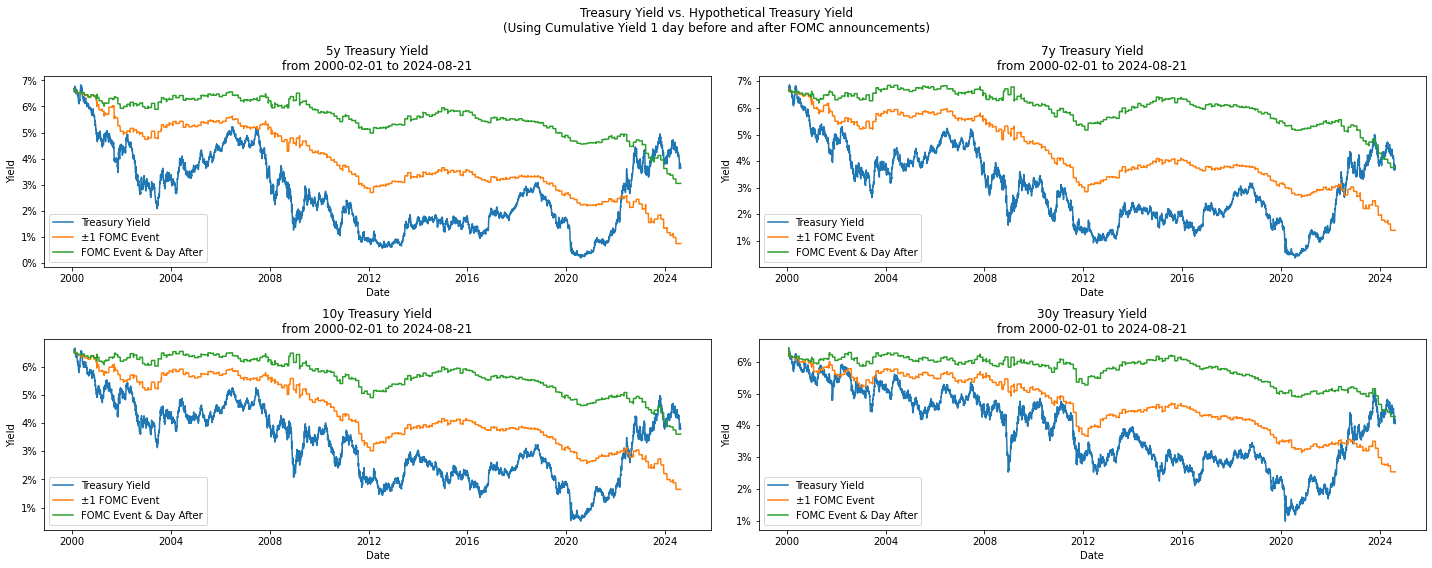

In [6]:
def plot_hypothetical_yield(df_hypothetical_yield: pd.DataFrame) -> plt.Figure: 
    
    renamer = {
        "DGS5": "5y",
        "DGS7": "7y",
        "DGS10": "10y",
        "DGS30": "30y"}
    
    col_renamer = {
        "raw_yield": "Treasury Yield",
        "three_day": "±1 FOMC Event",
        "ex_pre": "FOMC Event & Day After"}

    fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (20,8))

    for ticker, ax in zip(renamer.keys(), axes.flatten()):

        df_tmp = (df_hypothetical_yield.query(
            "variable == @ticker").
            rename(columns = {
                "test": "FOMC",
                "value": "yield"}).
            drop(columns = ["variable"]).
            set_index("Date").
            rename(columns = col_renamer))

        (df_tmp.plot(
            ax = ax,
            ylabel = "Yield",
            title = renamer[ticker] + " Treasury Yield\nfrom {} to {}".format(
                df_tmp.index.min(),
                df_tmp.index.max())))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))


    fig.suptitle("Treasury Yield vs. Hypothetical Treasury Yield\n(Using Cumulative Yield 1 day before and after FOMC announcements)")
    plt.tight_layout()
    
plot_hypothetical_yield(df_hypothetical_yield)